In [ ]:
import numpy as np

class Input:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def __init__(self, inputFeatures) -> None:
		self.inputShape = (-1, inputFeatures)
		self.outputShape = self.inputShape

	def forward(self, x):
		return x

	def backward(self, gradientLossWRTOutput, _):
		return gradientLossWRTOutput, None

	def getWeights(self):
		return None



class Dense:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #nodes)

	def __init__(self, numNodes) -> None:
		self.numNodes = numNodes

	# input shape: (batch_size, #features)
	def initPipeline(self, inputShape):
		inputFeatures = inputShape[1]
		self.features = inputFeatures

		self.weights = np.random.randn(self.numNodes, inputFeatures)
		# self.weights = np.ones((self.numNodes, inputFeatures))
		# print(self.weights.shape)
		self.bias = np.random.randn(self.numNodes, 1)
		# self.bias = np.ones((self.numNodes, 1))
		# print(self.bias.shape)
		self.outputShape = (-1, self.numNodes)

	# x shape: (batch_size, #features)
	def forward(self, x):
		self.x = x
		self.y = np.dot(self.weights, x.T) + self.bias
		self.y = self.y.T
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #nodes)

	def backward(self, gradientLossWRTOutput,optimizer):

		gradientLossWRTInput = np.dot(gradientLossWRTOutput, self.weights)


		gradientLossWRTWeights = np.dot(gradientLossWRTOutput.T, self.x)
		gradientLossWRTBias = np.sum(gradientLossWRTOutput, axis = 0, keepdims=True).T

		# print(f"gradientLossWRTWeights : {gradientLossWRTWeights.shape}")
		# print(f"gradientLossWRTbias : {gradientLossWRTBias.shape}")


		self.weights = optimizer.update(self.weights, gradientLossWRTWeights)
		self.bias = optimizer.update(self.bias, gradientLossWRTBias)

		# self.weights -= learningRate * gradientLossWRTWeights
		# self.bias -= learningRate * gradientLossWRTBias

		return gradientLossWRTInput, (gradientLossWRTWeights, gradientLossWRTBias)

	def getWeights(self):
		return (self.weights, self.bias)



class Softmax:
	def __init__(self) -> None:
		pass

	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def initPipeline(self, inputShape):
		self.inputShape = inputShape
		self.outputShape = inputShape

	def forward(self, x):
		self.x = x
		self.y =  np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)

	def backward(self, gradientLossWRTOutput, _):
		# gradientOutputWRT

		n , m = self.y.shape

		gradientOutputWRTInput = np.repeat(self.y, m, axis=0).reshape(n, m, m)
		gradientOutputWRTInput = np.multiply(gradientOutputWRTInput, np.transpose(gradientOutputWRTInput, axes=(0, 2, 1))) * -1

		diagElems = np.reshape(self.y, (n,  m , 1))
		diagElems = diagElems * (1 - diagElems)
		diagElems = np.eye(m) * diagElems
		mask = np.eye(m, dtype=bool)
		mask = np.tile(mask, (n, 1)).reshape(n, m, m)
		gradientOutputWRTInput[mask] = 0
		gradientOutputWRTInput = gradientOutputWRTInput + diagElems

		# jacobian_matrix = np.zeros((n, m, m))

		# for i in range(n):
		# 	# s = np.exp(self.x[i]) / np.sum(np.exp(self.x[i]), axis=1, keepdims=True)
		# 	s = self.y[i]
		# 	for j in range(n):
		# 		for k in range(n):
		# 			jacobian_matrix[i, j, k] = s[j] * (int(j == k) - s[k])


		# print(np.isclose(jacobian_matrix, gradientOutputWRTInput).all())
		# print(f"gradientLossWRTOutput : {np.expand_dims(gradientLossWRTOutput, -1).shape}")


		gradientLossWRTInput = np.matmul(gradientOutputWRTInput, np.expand_dims(gradientLossWRTOutput, -1))
		gradientLossWRTInput = np.squeeze(gradientLossWRTInput)

		# print(f"gradientLossWRTInput : {gradientLossWRTInput.shape}")

		return gradientLossWRTInput, None

	def getWeights(self):
		return None


class Relu:
	def __init__(self) -> None:
		pass

	def initPipeline(self, inputShape):
		self.inputShape = inputShape
		self.outputShape = inputShape

	def forward(self, x):
		self.x = x
		self.y = np.maximum(x, 0)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)
	def backward(self, gradientLossWRTOutput, _):
		gradientOutputWRTInput = np.where(self.x > 0, 1, 0)
		gradientLossWRTInput = np.multiply(gradientOutputWRTInput, gradientLossWRTOutput)
		return gradientLossWRTInput, None

	def getWeights(self):
		return None



class Model:
	def __init__(self, *layers) -> None:
		self.nLayers = len(layers)

		for i in range(1, self.nLayers):
			layers[i].initPipeline(layers[i-1].outputShape)

		self.layers = layers

	def predict(self, x):
		for layer in self.layers:
			x = layer.forward(x)
		return x

	def crossEntropyGradient(self, yTrue, yPred):
		return - yTrue / yPred

	def __backprop(self,yTrue, yPred, optimizer):
		# gradientLossWRTOutput = self.crossEntropyGradient(yTrue, yPred)
		gradientLossWRTOutput = self.squaredErrorGradient(yTrue, yPred)

		# print(f"loss grad wrt yhat : {gradientLossWRTOutput.shape}")
		# wAndg = []


		for layer in reversed(self.layers):
			gradientLossWRTOutput, g = layer.backward(gradientLossWRTOutput, optimizer)
			# wAndg.append((layer.getWeights(), g))

		# return wAndg

	def train(self, x, y, optimizer, epoch):
		for i in range(epoch):
			yPred = self.predict(x)
			# loss = self.__loss(y, yPred)
			# print(f"epoch {i} : {loss}")
			self.__backprop(y, yPred, optimizer)

	def squaredErrorGradient(self, yTrue, yPred):
		return -2 * (yTrue - yPred)




class GradientDescent:
	def __init__(self, learningRate) -> None:
		self.learningRate = learningRate

	def update(self, w, g):
		return w - self.learningRate * g


def eqn(x):
	return 2 * (x[0] ** 2) + 3.5 * x[1] + 7

def main():

	xs = []
	ys = []
	for i in range(100):
		x = np.random.randn(2)
		xs.append(x)
		ys.append(eqn(x))
	x = np.vstack(xs)
	y = np.vstack(ys)

	print(x.shape)
	print(y.shape)



	model = Model(
		Input(2),
		Dense(4),
		Relu(),
		Dense(3),
		Relu(),
		Dense(1)
		# Dense(3),
		# Dense(2),
		# Softmax()
		# Softmax()
	)
	# print(model.predict(x))
	# x = np.array([[1, -3], [-1, 1], [5, 6]])
	# y = np.array([[0, 1, 0], [1, 0, 0], [0,0, 1]])
	# print(x.shape)
	# yPred = model.predict(x)
	# print(f"ypred : {yPred}")
	# print(f"yPred.shape : {yPred.shape}")
	xt = np.array([[.5, .36]])

	# print(model.predict(xt))
	# print(eqn(xt[0]))

	print(np.sum(np.square(model.predict(x) - y)) / 100)

	model.train(x, y, GradientDescent(0.0001), 1000)

	print(np.sum(np.square(model.predict(x) - y)) / 100)


	# print(model.predict(x))


	print(model.predict(xt))
	print(eqn(xt[0]))
	# print(model.predict(x))



if __name__ == "__main__":
	main()


# Your initial array of shape (n, m)
# original_array = np.array([[1, 2, 3],
# 						[4, 5, 6]])

# n, m = original_array.shape

# # Repeat each row m times
# repeated_rows = np.repeat(original_array, m, axis=0)

# # Reshape the repeated array to (n, m, m)
# result_array = repeated_rows.reshape(n, m, m)

# # print(result_array)

# # print(np.reshape(original_array, (n,  m , 1)))

# diagElems = np.reshape(original_array, (n,  m , 1))
# # diagElems = original_array
# diagElems = diagElems * (1 - diagElems)
# diagElems = np.eye(m) * diagElems
# print(diagElems)

# mask = np.eye(m, dtype=bool)
# mask = np.tile(mask, (n, 1)).reshape(n, m, m)

# # result_array = np.fill_diagonal(result_array, diagElems)
# # np.fill_diagonal(result_array, 0)
# result_array[mask] = 0
# result_array = result_array + diagElems

# print(result_array)
# # print(diagElems)

# print(np.multiply(result_array, np.transpose(result_array, axes=(0, 2, 1))))


# print(np.multiply(result_array, np.reshape(original_array, (n, m, 1))))

In [35]:
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = ds.EMNIST(root = '/content/', split = 'letters', train = True, transform = transforms.ToTensor(), download = True)

100%|██████████| 561753746/561753746 [00:10<00:00, 51450151.91it/s]


Extracting /content/EMNIST/raw/gzip.zip to /content/EMNIST/raw


In [3]:
train

Dataset EMNIST
    Number of datapoints: 124800
    Root location: /content/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [48]:
(train.targets == 26).any()

tensor(True)

In [5]:
train.data.shape

torch.Size([124800, 28, 28])

In [ ]:
train.data[0]

In [18]:
tX, vX, tY, vY = train_test_split(train.data, train.targets, test_size = .15, random_state = 29)

In [19]:
tX.shape

torch.Size([106080, 28, 28])

In [27]:
def plot(img):
  plt.imshow(img, cmap = 'gray')
  plt.show()

In [49]:
def randomPlot(x, y):
  num_images = x.shape[0]
  indices = np.random.choice(num_images, 16, replace=False)

  # Plotting 16 random images
  plt.figure(figsize=(8, 8))
  for i, index in enumerate(indices, 1):
      plt.subplot(4, 4, i)
      plt.imshow(x[index], cmap='gray')
      plt.title(f"{chr(y[index] + ord('a') - 1)}", fontsize=10)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

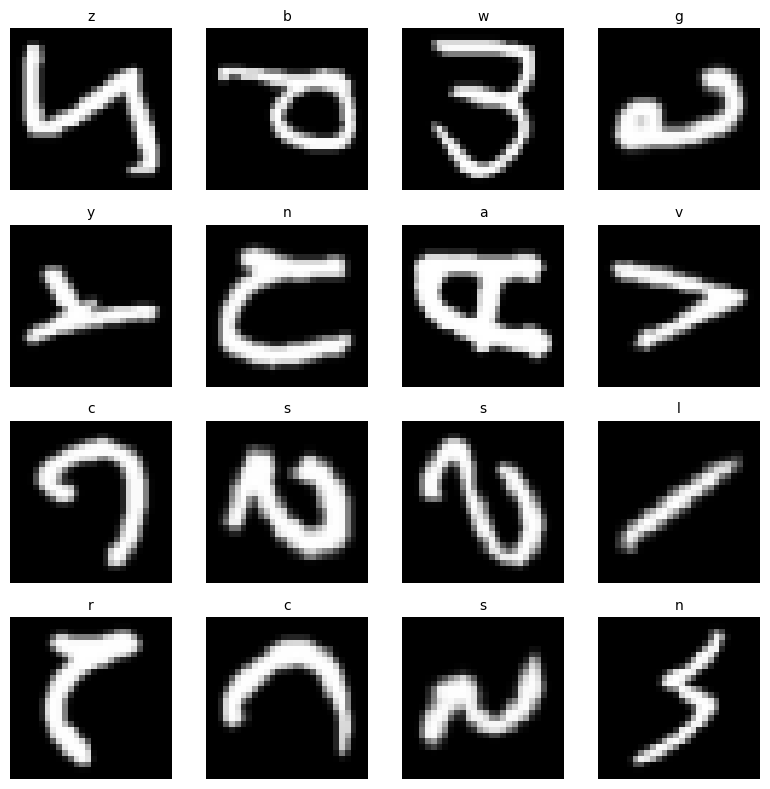

In [50]:
randomPlot(tX, tY)

In [ ]:
plot(vX[19])